### import

In [683]:
## 1. remove trash
!rm -rf ~/.local/share/Trash/files/*
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('image', cmap='Greys')
import rpy2 
%load_ext rpy2.ipython
%run pybase
%run heavysnow 
plt.style.use('ggplot')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### load data

In [861]:
n=23
f=np.array(pd.read_csv("2021-08-15-MCU-ticket.csv").Worldwide)/1000000
V=np.array(pd.read_csv("2021-08-15-MCU-ticket.csv").Film)
W=np.array(pd.read_csv("2021-08-15-MCU-weights.csv",index_col=0))-np.eye(n,n)

### HST

In [1132]:
gs=GraphSignal(V,W,f)
hst=HeavysnowTransform(gs)
hst.snow(tau=40000,b=1)

HST (tau= 40000, b=1)
40000/40000
HST completed and all history is recorded.


In [1186]:
hst.adjustingtheta(140)

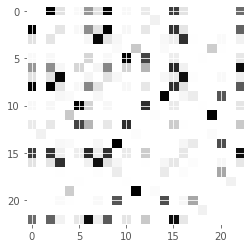

In [1187]:
plt.imshow(hst.snowweight)

### R 환경으로.. 

In [1188]:
import rpy2 
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [1189]:
n=hst.n 
V=hst.V
f=hst.f 
WEuclid= hst.euclidweight
Wgraph= (hst.graphweight+hst.graphweight.T)/2
Whst= hst.snowweight
W= hst.graphweight

In [1190]:
%R -i n
%R -i V
%R -i f
%R -i WEuclid
%R -i Wgraph
%R -i Whst
%R -i W

### 유클리드와 그래프도메인의 정보를 플랏. 

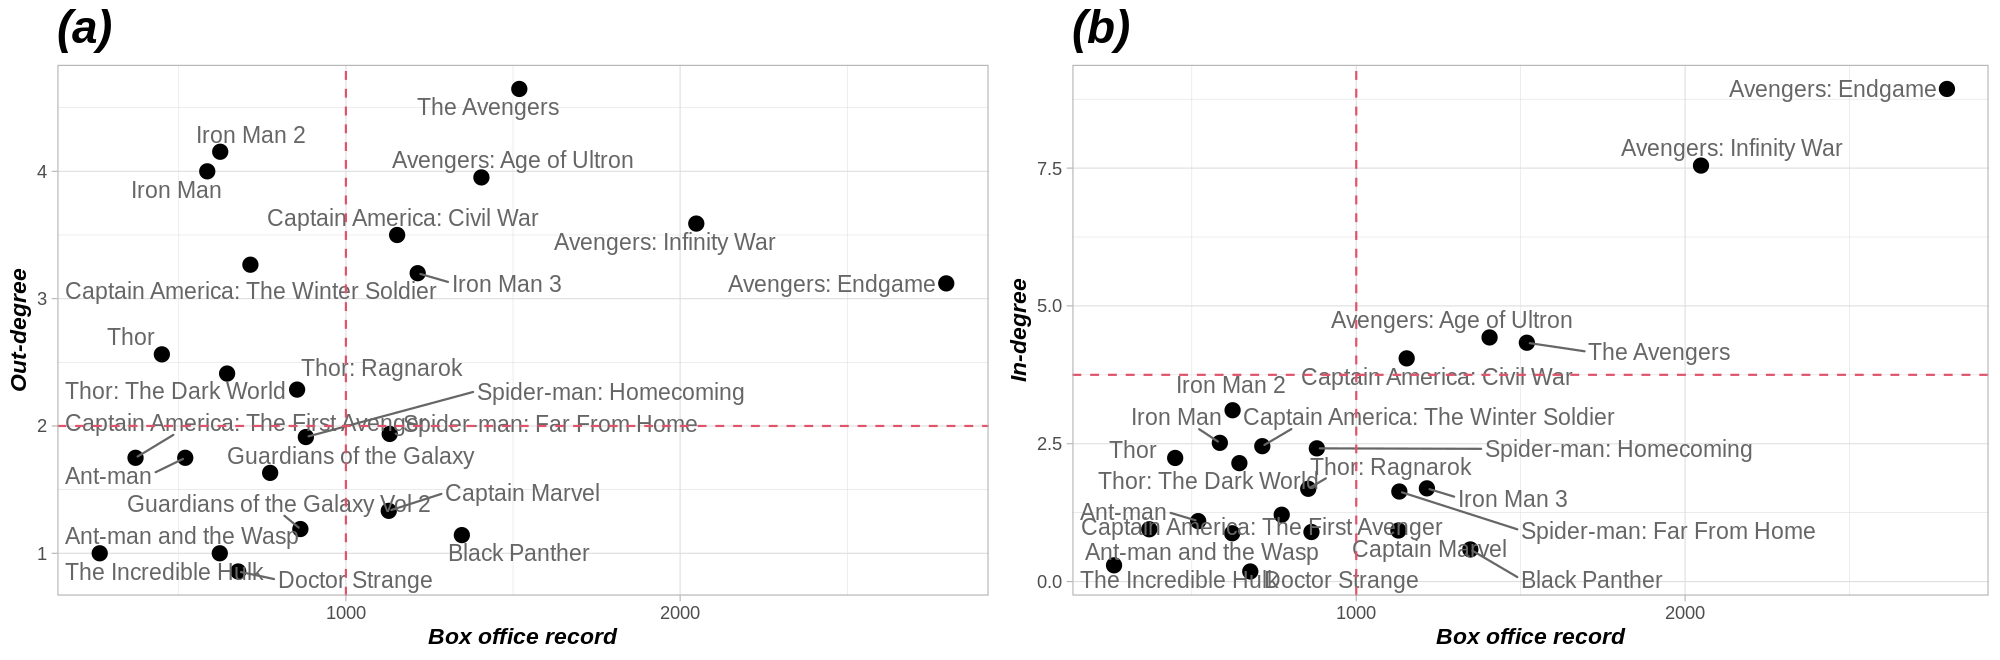

In [1191]:
%%R -r 150 -w 2000 -h 660
source('heavysnow.R')
dat_<-tibble(V)
dat_$f<-as.vector(f)
dat_$divlink<-0
dat_$conlink<-0
dat_$link<-0
dat<-dat_
for(i in 1:23){
    dat$divlink[i]<-sum(W[i,])
    dat$conlink[i]<-sum(W[,i])
    dat$link[i]<-sum(W[i,])+sum(W[i,])
}
p1_<-ggplot(dat)+geom_point(aes(x=f,y=divlink),size=3)+theme_light()+
        geom_text_repel(aes(x=f,y=divlink,label=V),col="gray40")+
        ylab("Out-degree")+xlab("Box office record")+
        geom_hline(aes(yintercept=2),col=2,lty=2,lwd=0.5)+
        geom_vline(aes(xintercept=1000),col=2,lty=2,lwd=0.5)+
        ggtitle("(a)")+theme(plot.title=element_text(face="bold.italic",size=rel(2)))+
        theme(axis.title.x=element_text(face=4,size=rel(1)))+
        theme(axis.title.y=element_text(face=4,size=rel(1)))
p2_<-ggplot(dat)+geom_point(aes(x=f,y=conlink),size=3)+theme_light()+
        geom_text_repel(aes(x=f,y=conlink,label=V),col="gray40")+
        ylab("In-degree")+xlab("Box office record")+
        geom_hline(aes(yintercept=3.75),col=2,lty=2,lwd=0.5)+
        geom_vline(aes(xintercept=1000),col=2,lty=2,lwd=0.5)+
        ggtitle("(b)")+theme(plot.title=element_text(face="bold.italic",size=rel(2)))+
        theme(axis.title.x=element_text(face=4,size=rel(1)))+
        theme(axis.title.y=element_text(face=4,size=rel(1)))
# p3_<-ggplot(dat)+geom_point(aes(x=f,y=link),size=3)+theme_light()+
#         geom_text_repel(aes(x=f,y=link,label=V),col="gray40")+
#         ylab("Graph")+xlab("Box office record")+
#         geom_hline(aes(yintercept=6.25),col=2,lty=2,lwd=0.5)+
#         geom_vline(aes(xintercept=1000),col=2,lty=2,lwd=0.5)+
#         ggtitle("(c)")
p1<-grid.arrange(p1_,p2_,ncol=2)
#ggsave(plot=p1,"./fig/p1.pdf",width=9,height=4.5)

### gfft 수행하고 결과를 저장함. 

In [1192]:
%%R 
g1<-gfft(f,WEuclid)
g2<-gfft(f,Wgraph)
g3<-gfft(f,Whst)

### 아이겐플랏 


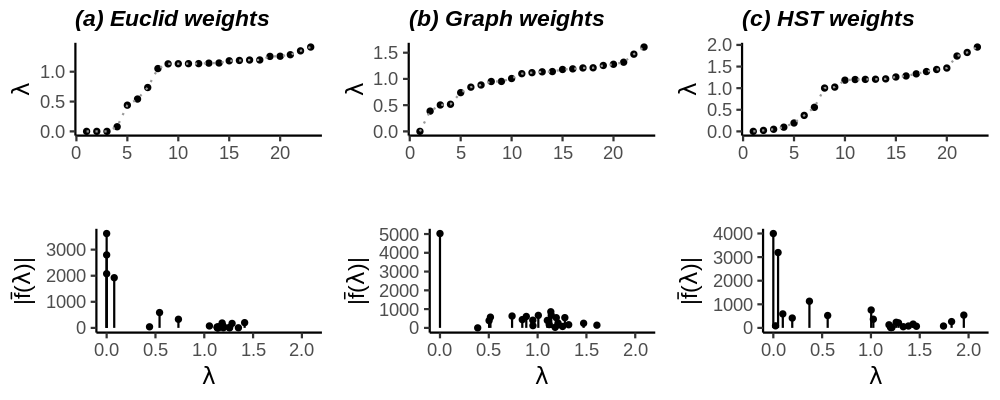

In [1193]:
%%R -r 150 -w 1000 -h 400
library(gridExtra)
e1<-eigenplot(g1)+ggtitle("(a) Euclid weights")+theme(plot.title=element_text(face="bold.italic",size=rel(1)))
e2<-eigenplot(g2)+ggtitle("(b) Graph weights")+theme(plot.title=element_text(face="bold.italic",size=rel(1)))
e3<-eigenplot(g3)+ggtitle("(c) HST weights")+theme(plot.title=element_text(face="bold.italic",size=rel(1)))
s1<-specplot(g1)
s2<-specplot(g2)
s3<-specplot(g3)
p2<-grid.arrange(e1,e2,e3,s1,s2,s3,nrow=2)
#ggsave(plot=p2,"./fig/p2.pdf",width=6,height=3)

### 분해 

In [1194]:
%%R -r 300 -w 2500 -h 1500
d1<-decompose(f,WEuclid,V=V) # 0, 35000, 60000, 80000
d2<-decompose(f,Wgraph,V=V) # 0, 35000, 60000, 80000
d3<-decompose(f,Whst,V=V) # 0, 35000, 60000, 80000

d1$case<-"Euclid"
d2$case<-"Graph"
d3$case<-"HST"
decomprslt<-rbind(d1,d2,d3)

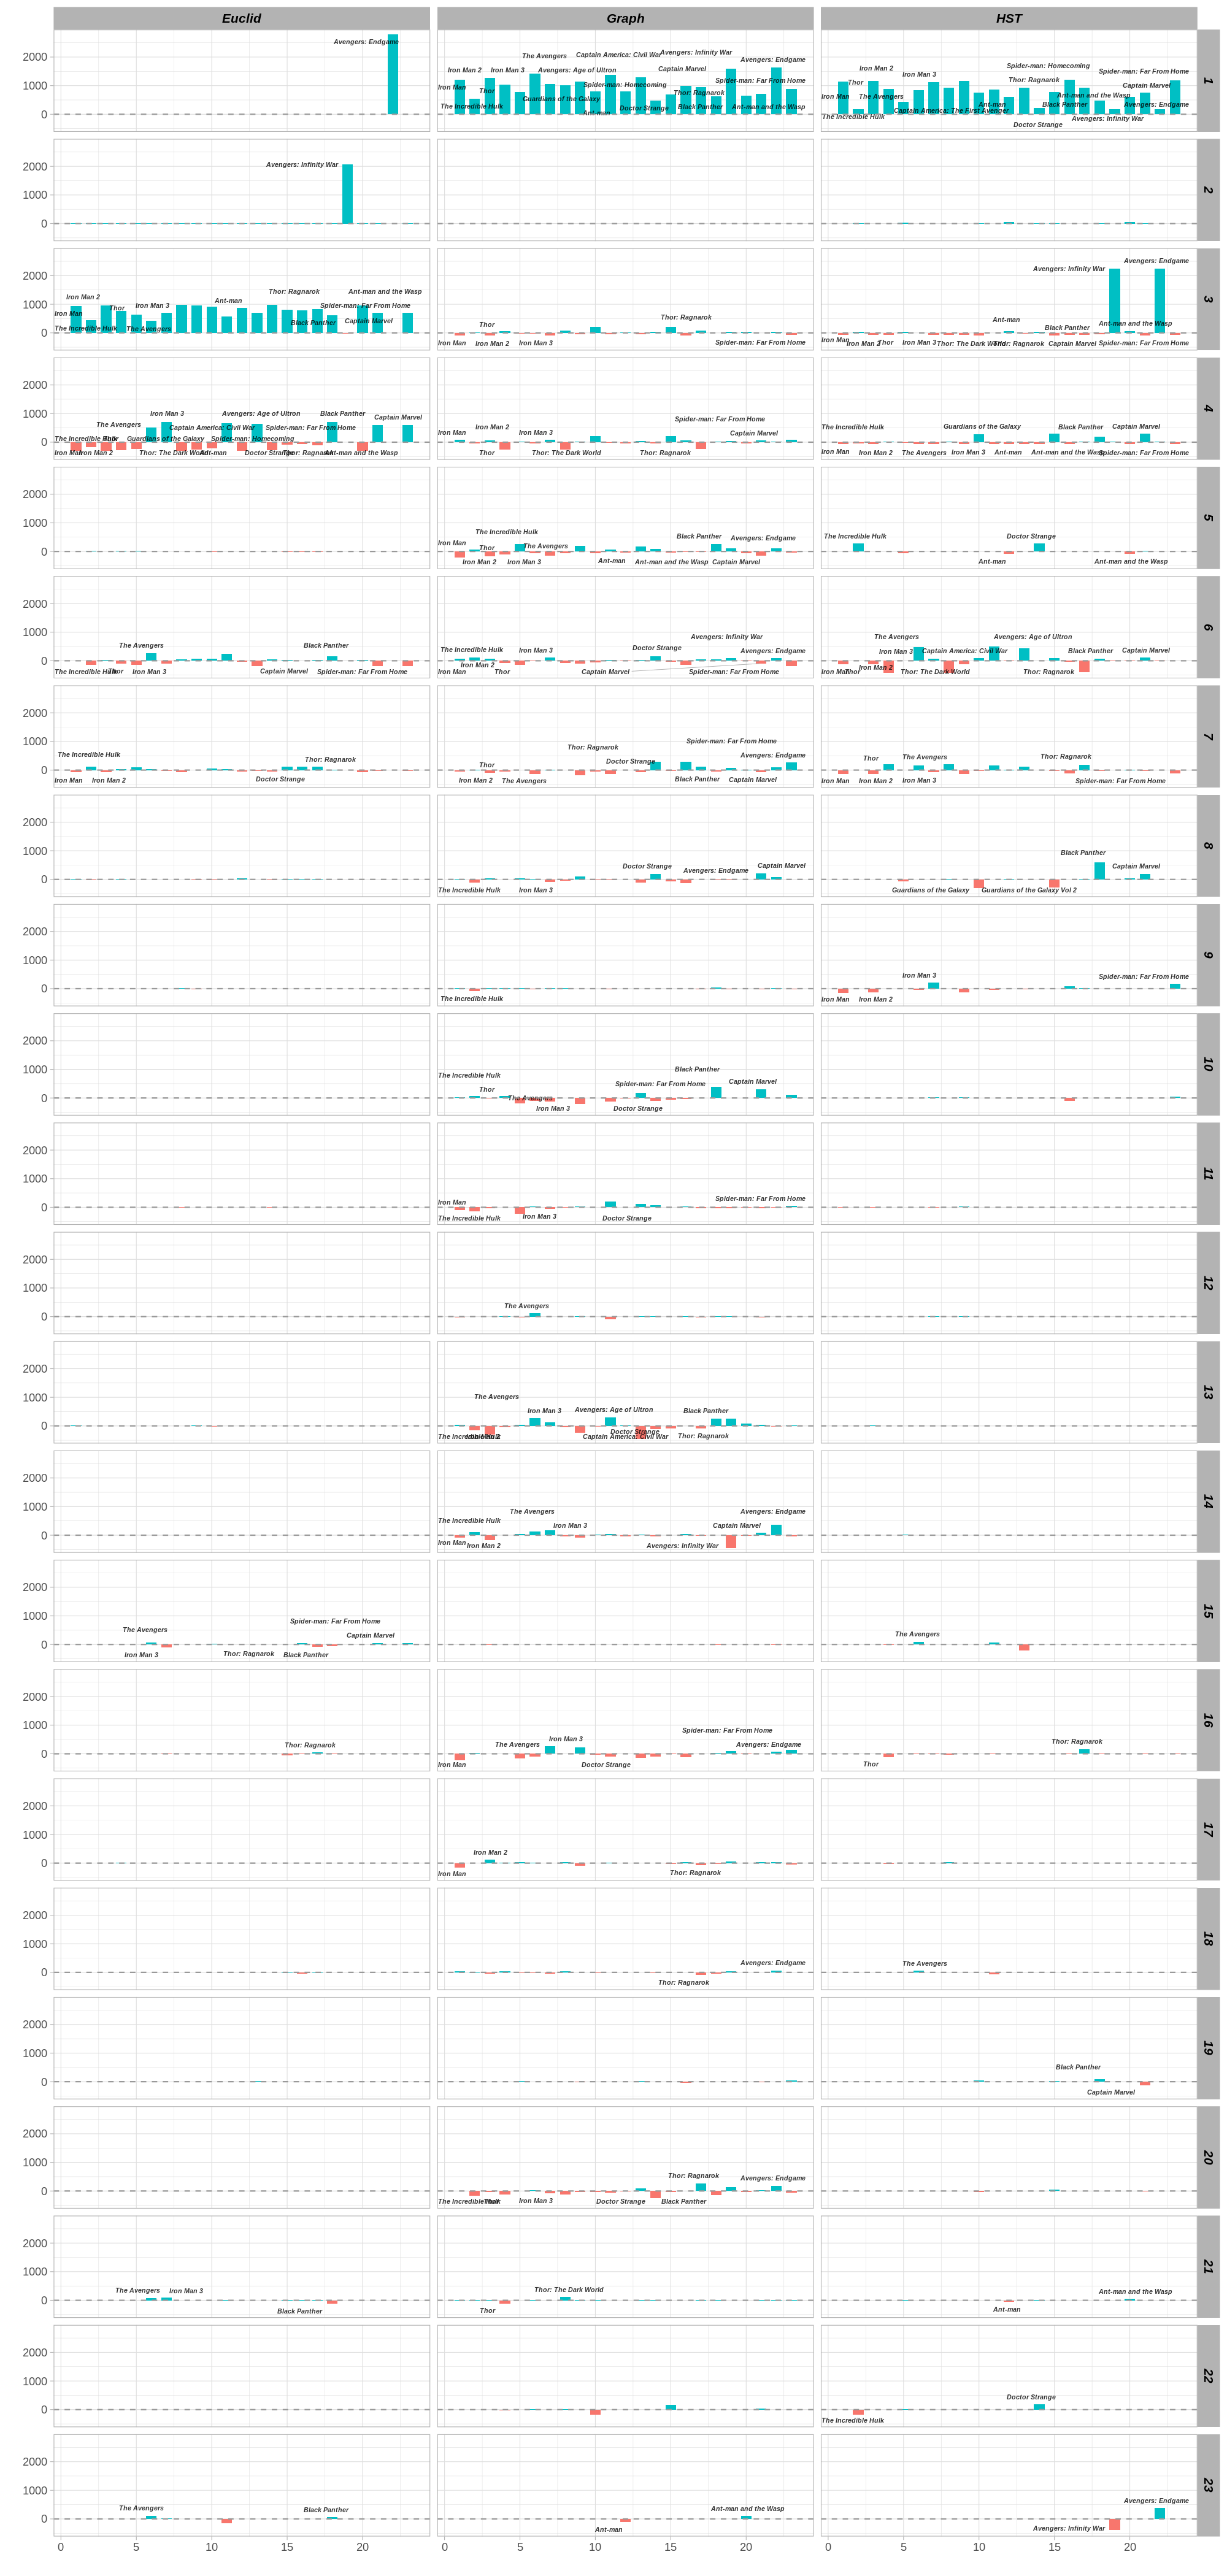

In [1195]:
%%R -r 150 -w 2000 -h 4200

decomp_dat<- decomprslt %>% 
                group_by(case,eigenvectorindex) %>% 
                mutate(textsize= 10*(abs(fhat)>50))
        
p3<-ggplot(data=filter(decomp_dat,eigenvectorindex %in% 1:23))+
    geom_col(aes(x=Vindex,y=fhat,fill=fhat>0),width=0.7)+
    geom_text_repel(aes(x=Vindex,y=fhat,label=V,size=textsize),col=1,fontface=4,alpha=0.8,segment.size=0.2,segment.color="gray60",min.segment.length=5,hjust=0.1)+
    scale_radius(range = c(0,1.8))+
    guides(size=FALSE)+
    facet_grid(eigenvectorindex~case)+
    geom_hline(aes(yintercept=0),col="gray60",lty=2)+
    xlab("")+ylab("")+guides(fill=FALSE)+
    theme(axis.text.x=element_text(angle=85,hjust=1,vjust=1,face=4,size=rel(0.7),colour="gray60"))+
    theme_light()+
    theme(strip.text.x = element_text(size = 10, color = "black", face = "bold.italic"))+
    theme(strip.text.y = element_text(size = 10, color = "black", face = "bold.italic"))+
    theme(plot.title=element_text(face="bold.italic",size=rel(1.5)))
show(p3)

# decomp_dat<- decomprslt %>% 
#                 group_by(case,eigenvectorindex) %>% 
#                 mutate(textsize=(fhat>mean(fhat)) *(fhat>240) * ((case=="Euclid")*1.7+
#                                                                  (case!="Euclid")*(eigenvectorindex!=1)*1.7+
#                                                                  (case!="Euclid")*(eigenvectorindex==1)*1))


# p3<-ggplot(data=filter(decomp_dat,eigenvectorindex %in% 1:7))+
#     geom_col(aes(x=Vindex,y=fhat,fill=fhat>0),width=0.7)+
#     geom_text_repel(aes(x=Vindex,y=fhat,label=V,size=textsize),col=1,fontface=4,alpha=0.8,segment.size=0.2,segment.color="gray60",min.segment.length=5,hjust=0.1)+
#     scale_radius(range = c(0,1.8))+
#     guides(size=FALSE)+
#     facet_grid(eigenvectorindex~case)+
#     geom_hline(aes(yintercept=0),col="gray60",lty=2)+
#     xlab("")+ylab("")+guides(fill=FALSE)+
#     theme(axis.text.x=element_text(angle=85,hjust=1,vjust=1,face=4,size=rel(0.7),colour="gray60"))+
#     theme_light()+
#     theme(strip.text.x = element_text(size = 10, color = "black", face = "bold.italic"))+
#     theme(strip.text.y = element_text(size = 10, color = "black", face = "bold.italic"))+
#     theme(plot.title=element_text(face="bold.italic",size=rel(1.5)))
# show(p3)
#ggsave(plot=p3,"./fig/p3.pdf",width=6,height=6)

In [1196]:
%%R
dat3_Euclid <- decomp_dat %>% filter(case=="Euclid",eigenvectorindex==1) %>% select(V,case,eigenvectorindex,textsize,fhat)
dat3_Euclid <- left_join(dat,dat3_Euclid,by="V")

for(j in 2:23){
        decomp_filtered_dat_<- decomp_dat %>% filter(case=="Euclid",eigenvectorindex==j) %>% select(V,case,eigenvectorindex,textsize,fhat)
        decomp_filtered_dat_<- left_join(dat,decomp_filtered_dat_,by="V")
        dat3_Euclid<-rbind(dat3_Euclid,decomp_filtered_dat_)
}

dat3_Graph <- decomp_dat %>% filter(case=="Graph",eigenvectorindex==1) %>% select(V,case,eigenvectorindex,textsize,fhat)
dat3_Graph <- left_join(dat,dat3_Graph,by="V")

for(j in 2:23){
        decomp_filtered_dat_<- decomp_dat %>% filter(case=="Graph",eigenvectorindex==j) %>% select(V,case,eigenvectorindex,textsize,fhat)
        decomp_filtered_dat_<- left_join(dat,decomp_filtered_dat_,by="V")
        dat3_Graph<-rbind(dat3_Graph,decomp_filtered_dat_)
}

dat3_HST <- decomp_dat %>% filter(case=="HST",eigenvectorindex==1) %>% select(V,case,eigenvectorindex,textsize,fhat)
dat3_HST <- left_join(dat,dat3_HST,by="V")

for(j in 2:23){
        decomp_filtered_dat_<- decomp_dat %>% filter(case=="HST",eigenvectorindex==j) %>% select(V,case,eigenvectorindex,textsize,fhat)
        decomp_filtered_dat_<- left_join(dat,decomp_filtered_dat_,by="V")
        dat3_HST<-rbind(dat3_HST,decomp_filtered_dat_)
}
dat3<-rbind(dat3_Euclid,dat3_Graph,dat3_HST)

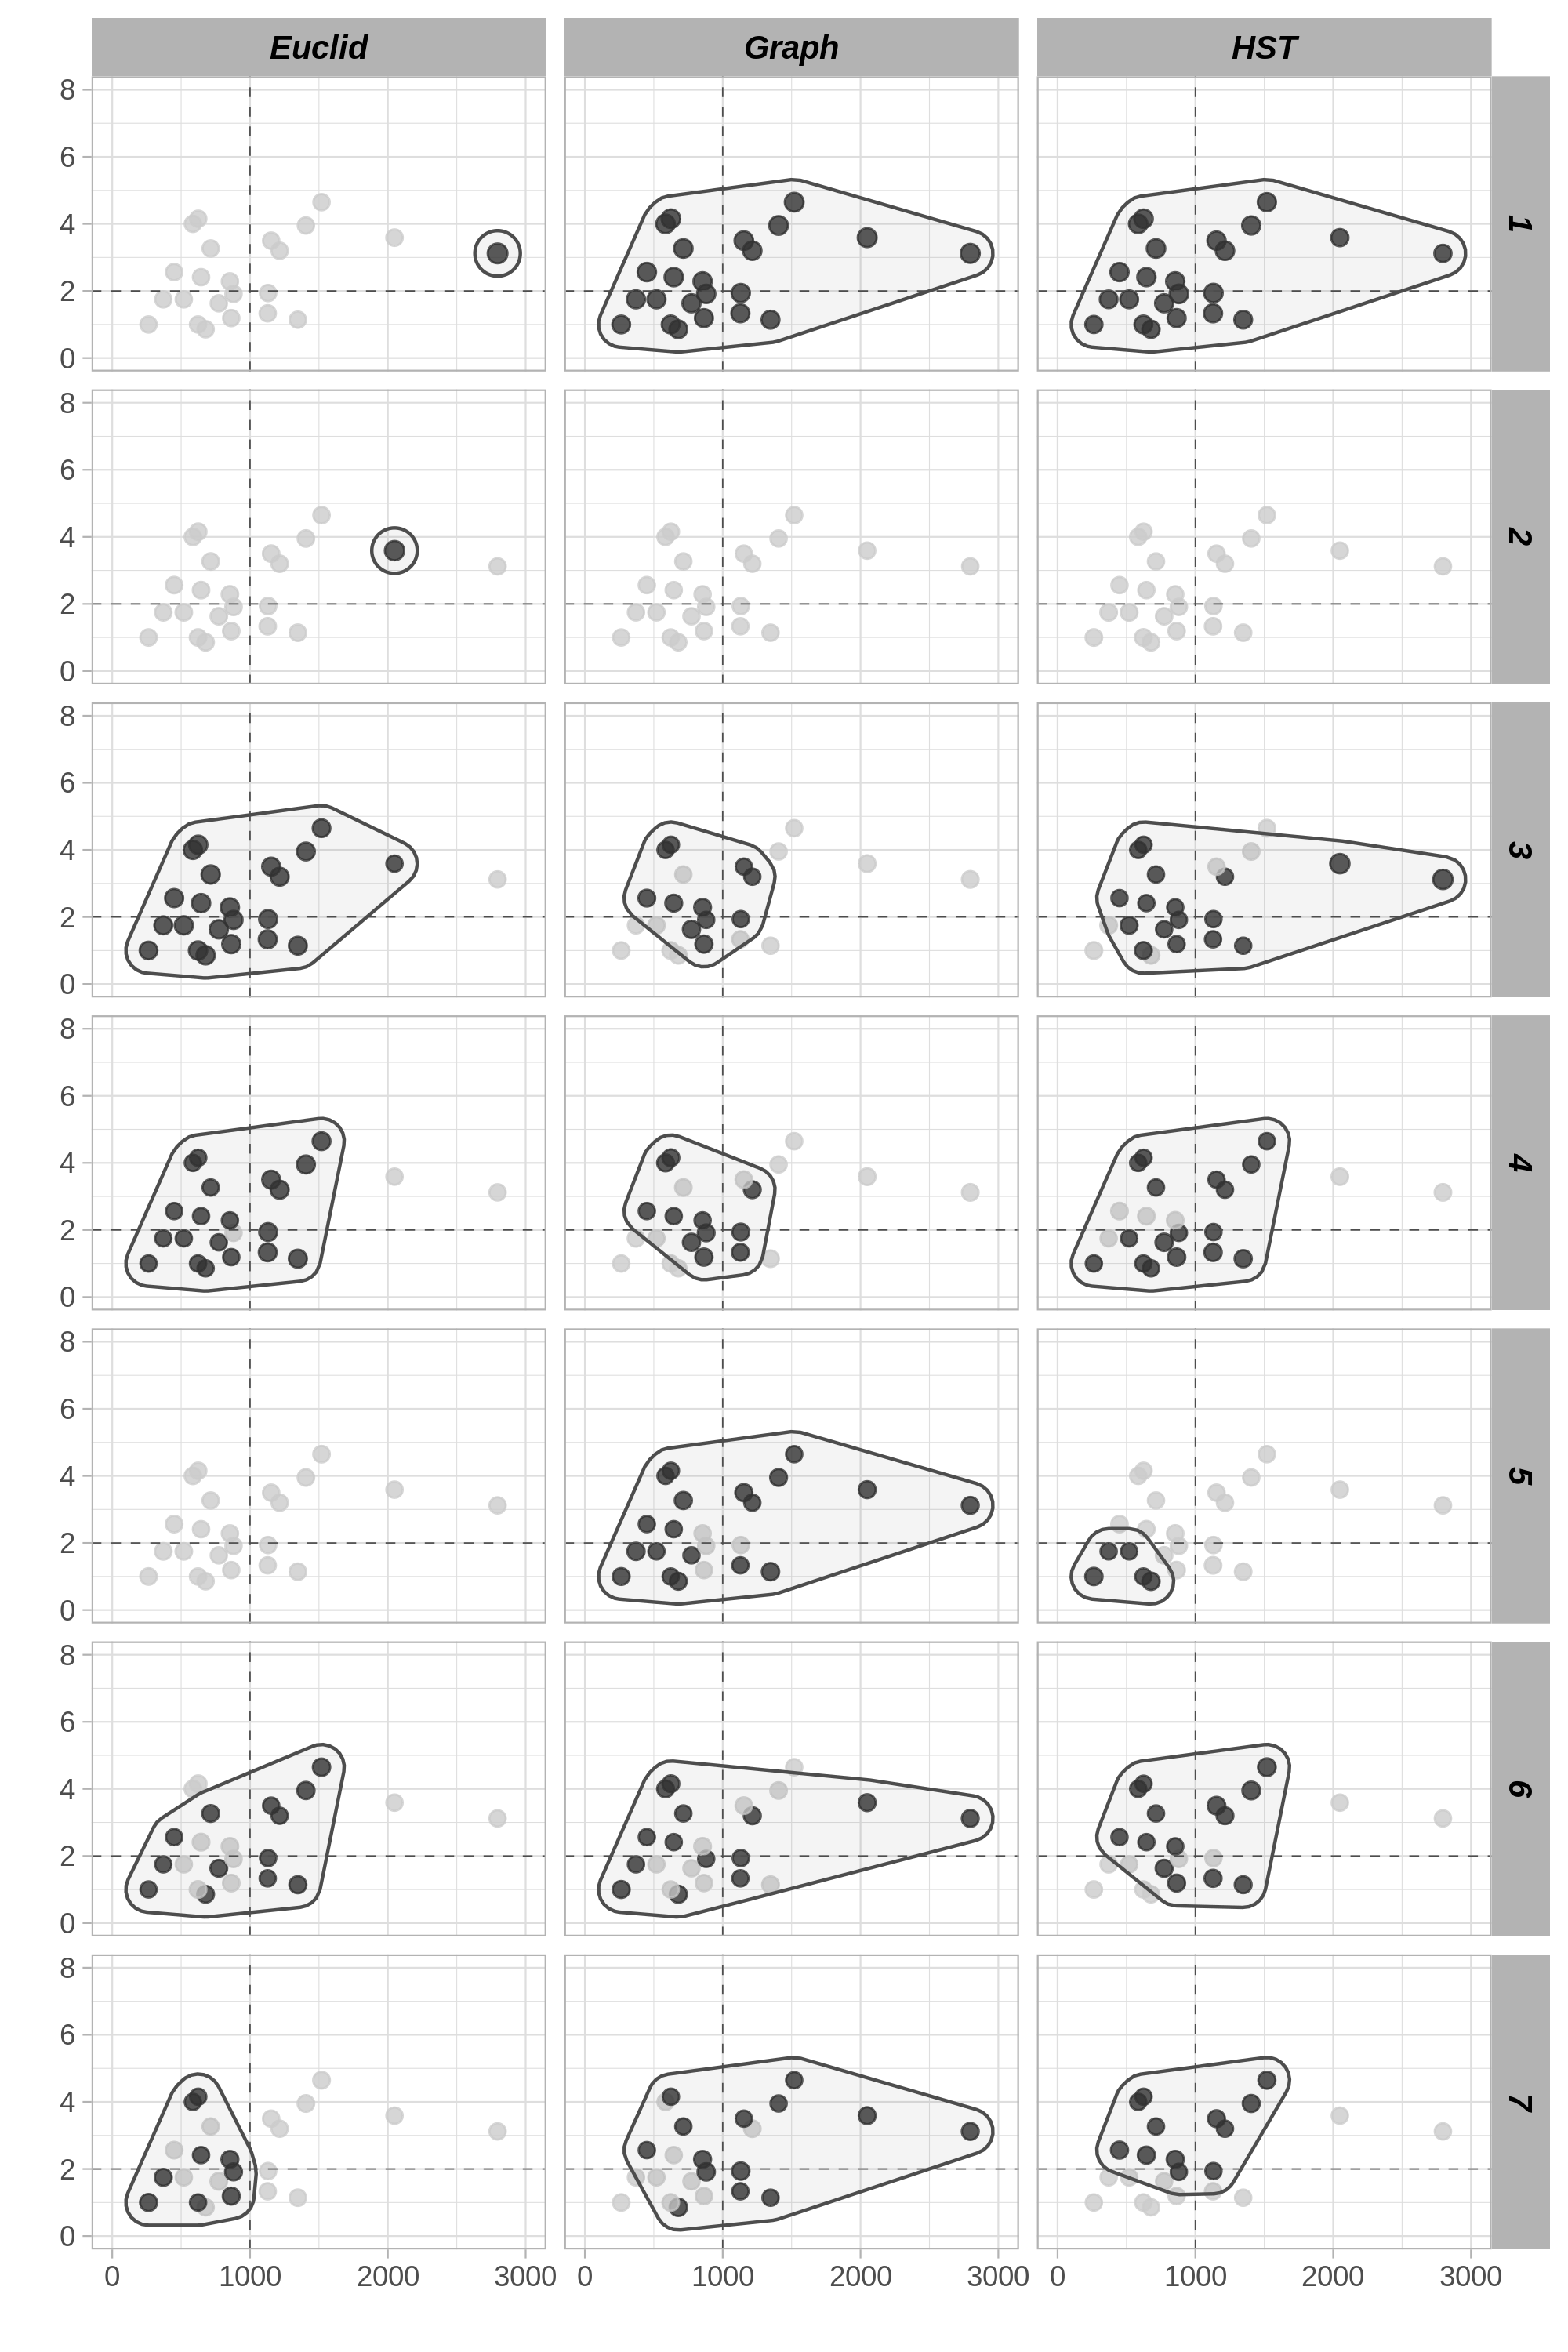

In [1144]:
%%R -r 300 -w 2000 -h 3000
hull_cyl <- dat3 %>%
            group_by(case,eigenvectorindex) %>% 
            filter(textsize>0) %>% 
            slice(chull(f, divlink))
p4<-ggplot(dat3%>% filter(eigenvectorindex<8))+geom_point(aes(x=f,y=divlink,col=textsize>0,size=fhat*(fhat>0)),alpha=0.8)+
        geom_shape(data=hull_cyl%>% filter(eigenvectorindex<8) ,aes(x=f,y=divlink),alpha=0.05,col="gray30",radius=0.05,expand=0.05)+
        facet_grid(eigenvectorindex~case)+
        scale_size_continuous(range=c(2,2.5))+
        scale_color_manual(values=c("gray80", "gray20"))+
        ylim(0,8)+xlim(0,3000)+
        guides(alpha=F)+
        guides(col=F)+
        guides(size=F)+
        ylab("")+xlab("")+
        geom_hline(aes(yintercept=2),col="gray30",lty=2,lwd=0.2)+
        geom_vline(aes(xintercept=1000),col="gray30",lty=2,lwd=0.2)+
        theme_light()+
        theme(strip.text.x = element_text(size = 10, color = "black", face = "bold.italic"))+
        theme(strip.text.y = element_text(size = 10, color = "black", face = "bold.italic"))+
        theme(plot.title=element_text(face="bold.italic",size=rel(1.5)))
show(p4)
#ggsave(plot=p4,"./fig/p4.pdf",width=7,height=7)

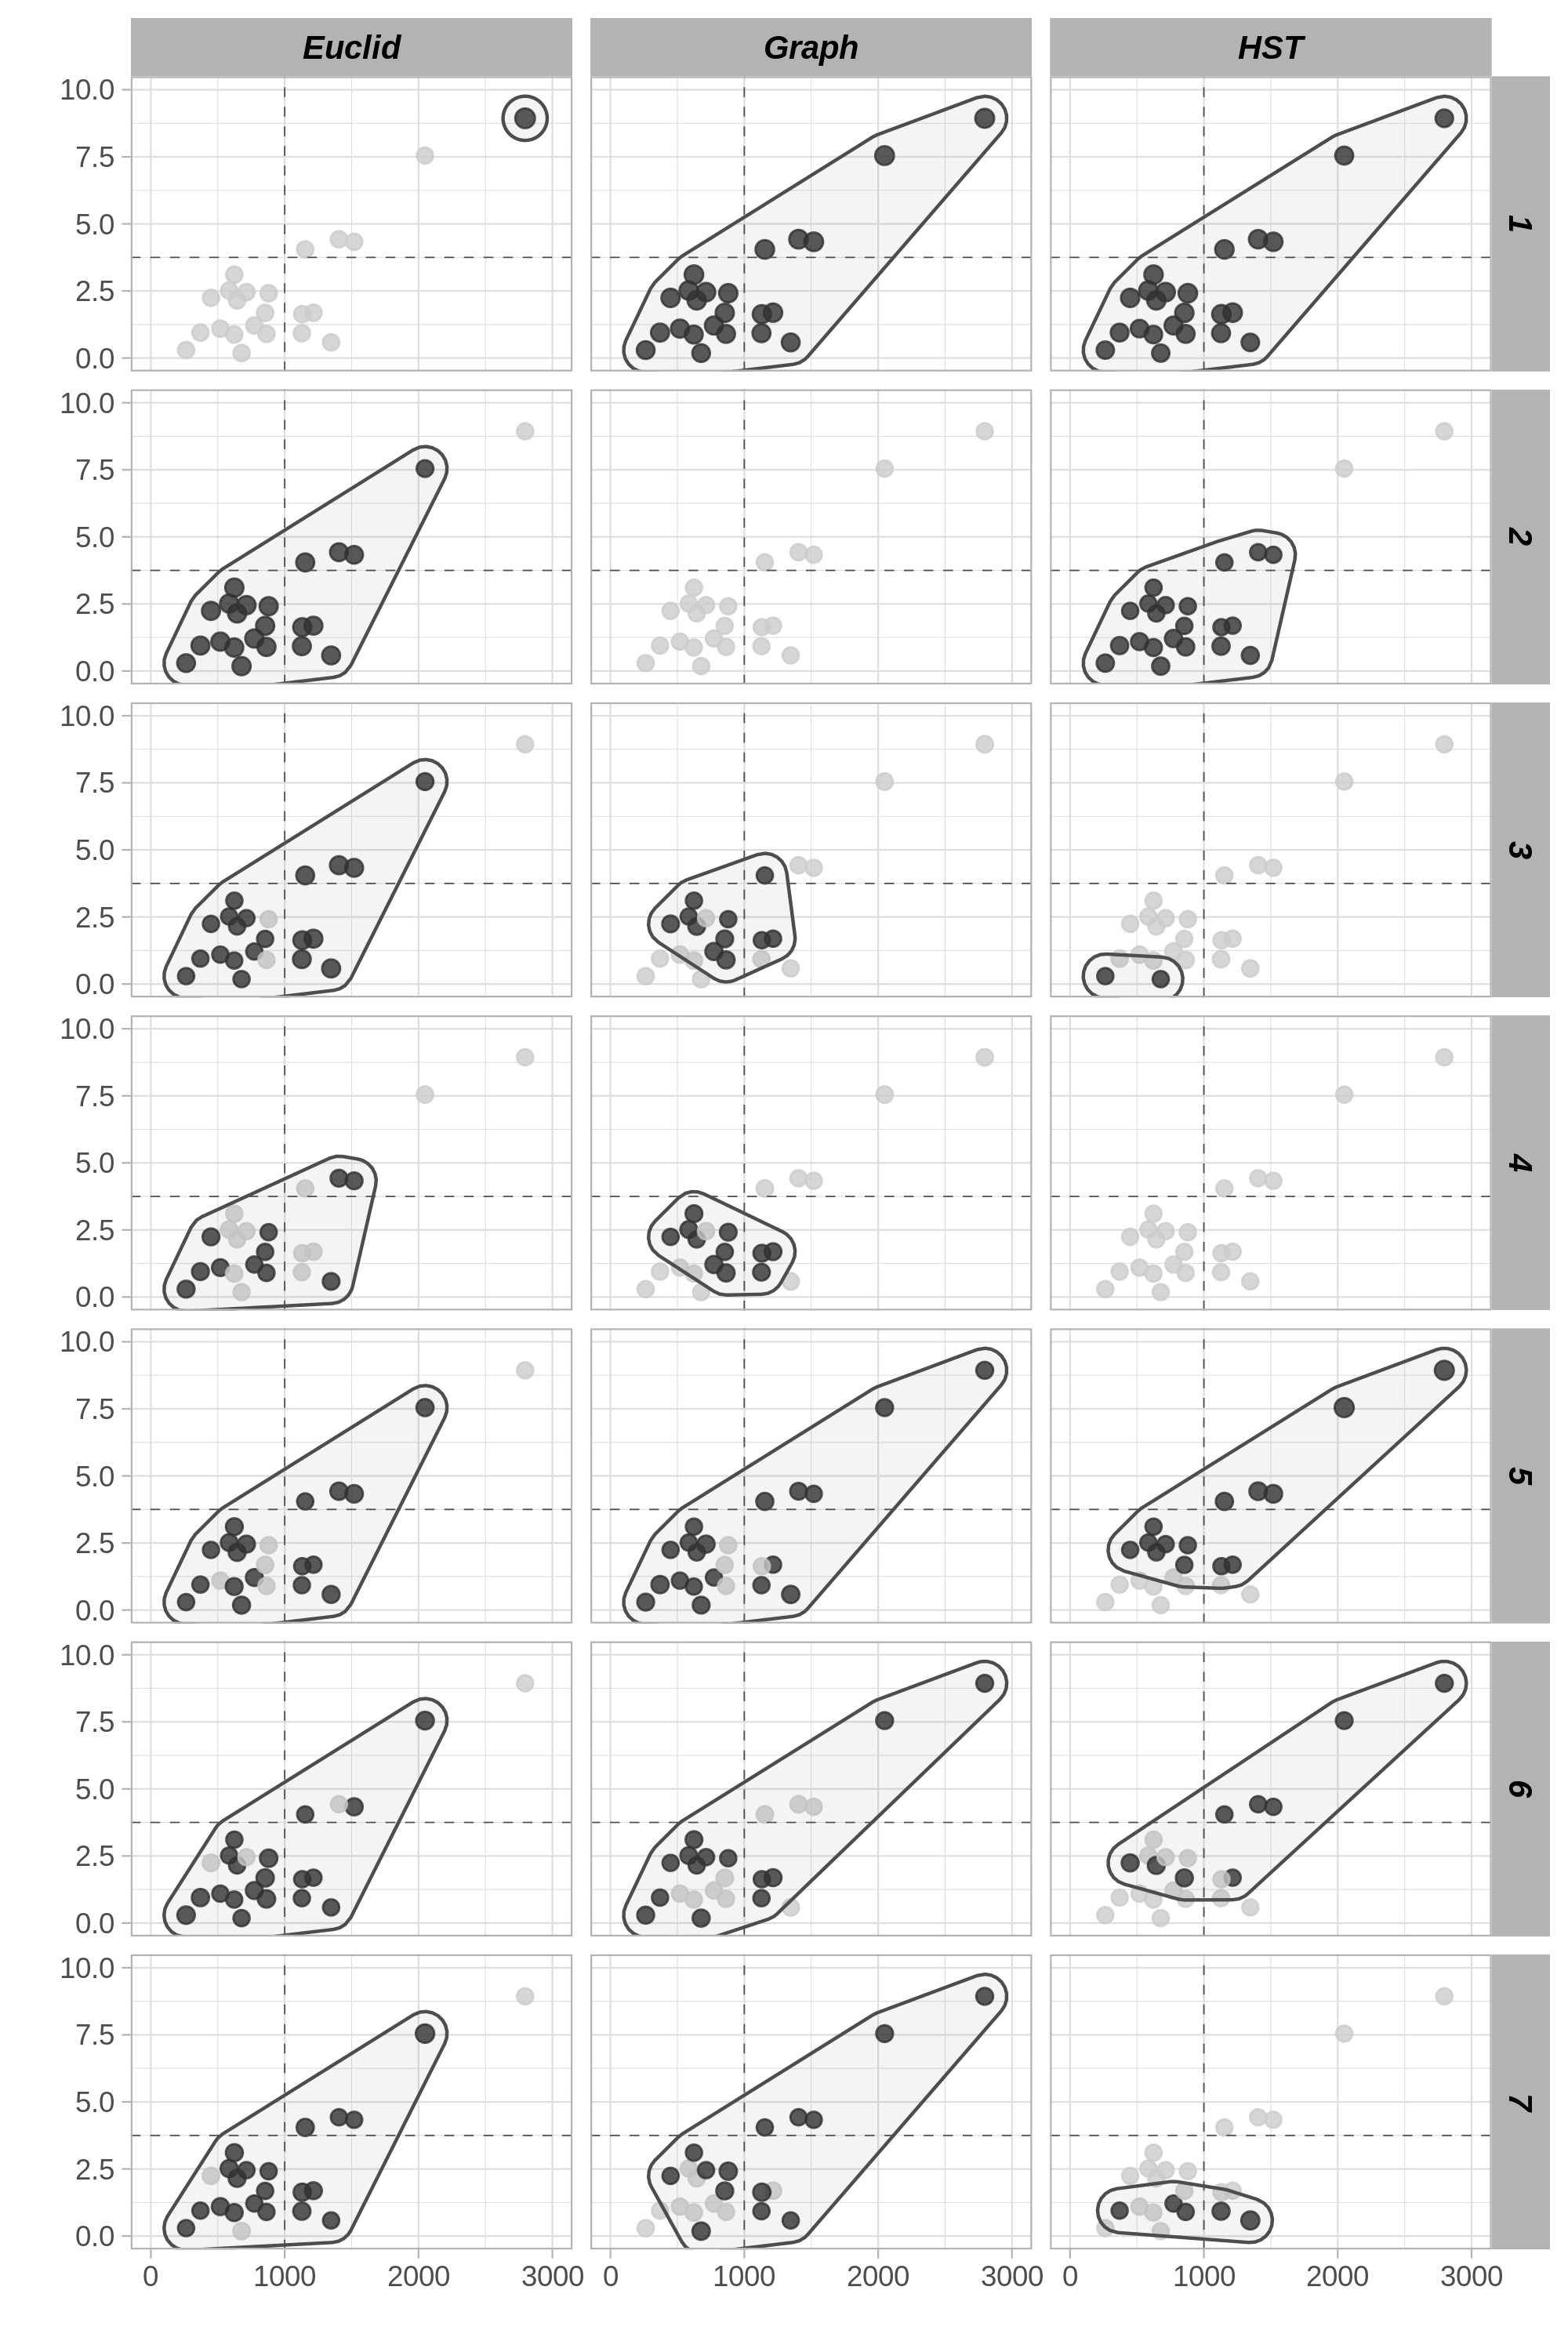

In [1020]:
%%R -r 300 -w 2000 -h 3000
hull_cyl <- dat3 %>%
            group_by(case,eigenvectorindex) %>% 
            filter(textsize>0) %>% 
            slice(chull(f, conlink))
p5<-ggplot(dat3%>% filter(eigenvectorindex<8))+geom_point(aes(x=f,y=conlink,col=textsize>0,size=fhat*(fhat>0)),alpha=0.8)+
        geom_shape(data=hull_cyl%>% filter(eigenvectorindex<8) ,aes(x=f,y=conlink),alpha=0.05,col="gray30",radius=0.05,expand=0.05)+
        facet_grid(eigenvectorindex~case)+
        scale_size_continuous(range=c(2,2.5))+
        scale_color_manual(values=c("gray80", "gray20"))+        
        ylim(0,10)+xlim(0,3000)+
        guides(col=F)+
        guides(alpha=F)+
        guides(size=F)+       
        ylab("")+xlab("")+
        geom_hline(aes(yintercept=3.75),col="gray30",lty=2,lwd=0.2)+
        geom_vline(aes(xintercept=1000),col="gray30",lty=2,lwd=0.2)+
        theme_light()+
        theme(strip.text.x = element_text(size = 10, color = "black", face = "bold.italic"))+
        theme(strip.text.y = element_text(size = 10, color = "black", face = "bold.italic"))+
        theme(plot.title=element_text(face="bold.italic",size=rel(1.5)))
show(p5)
#ggsave(plot=p5,"./fig/p5.pdf",width=7,height=7)        

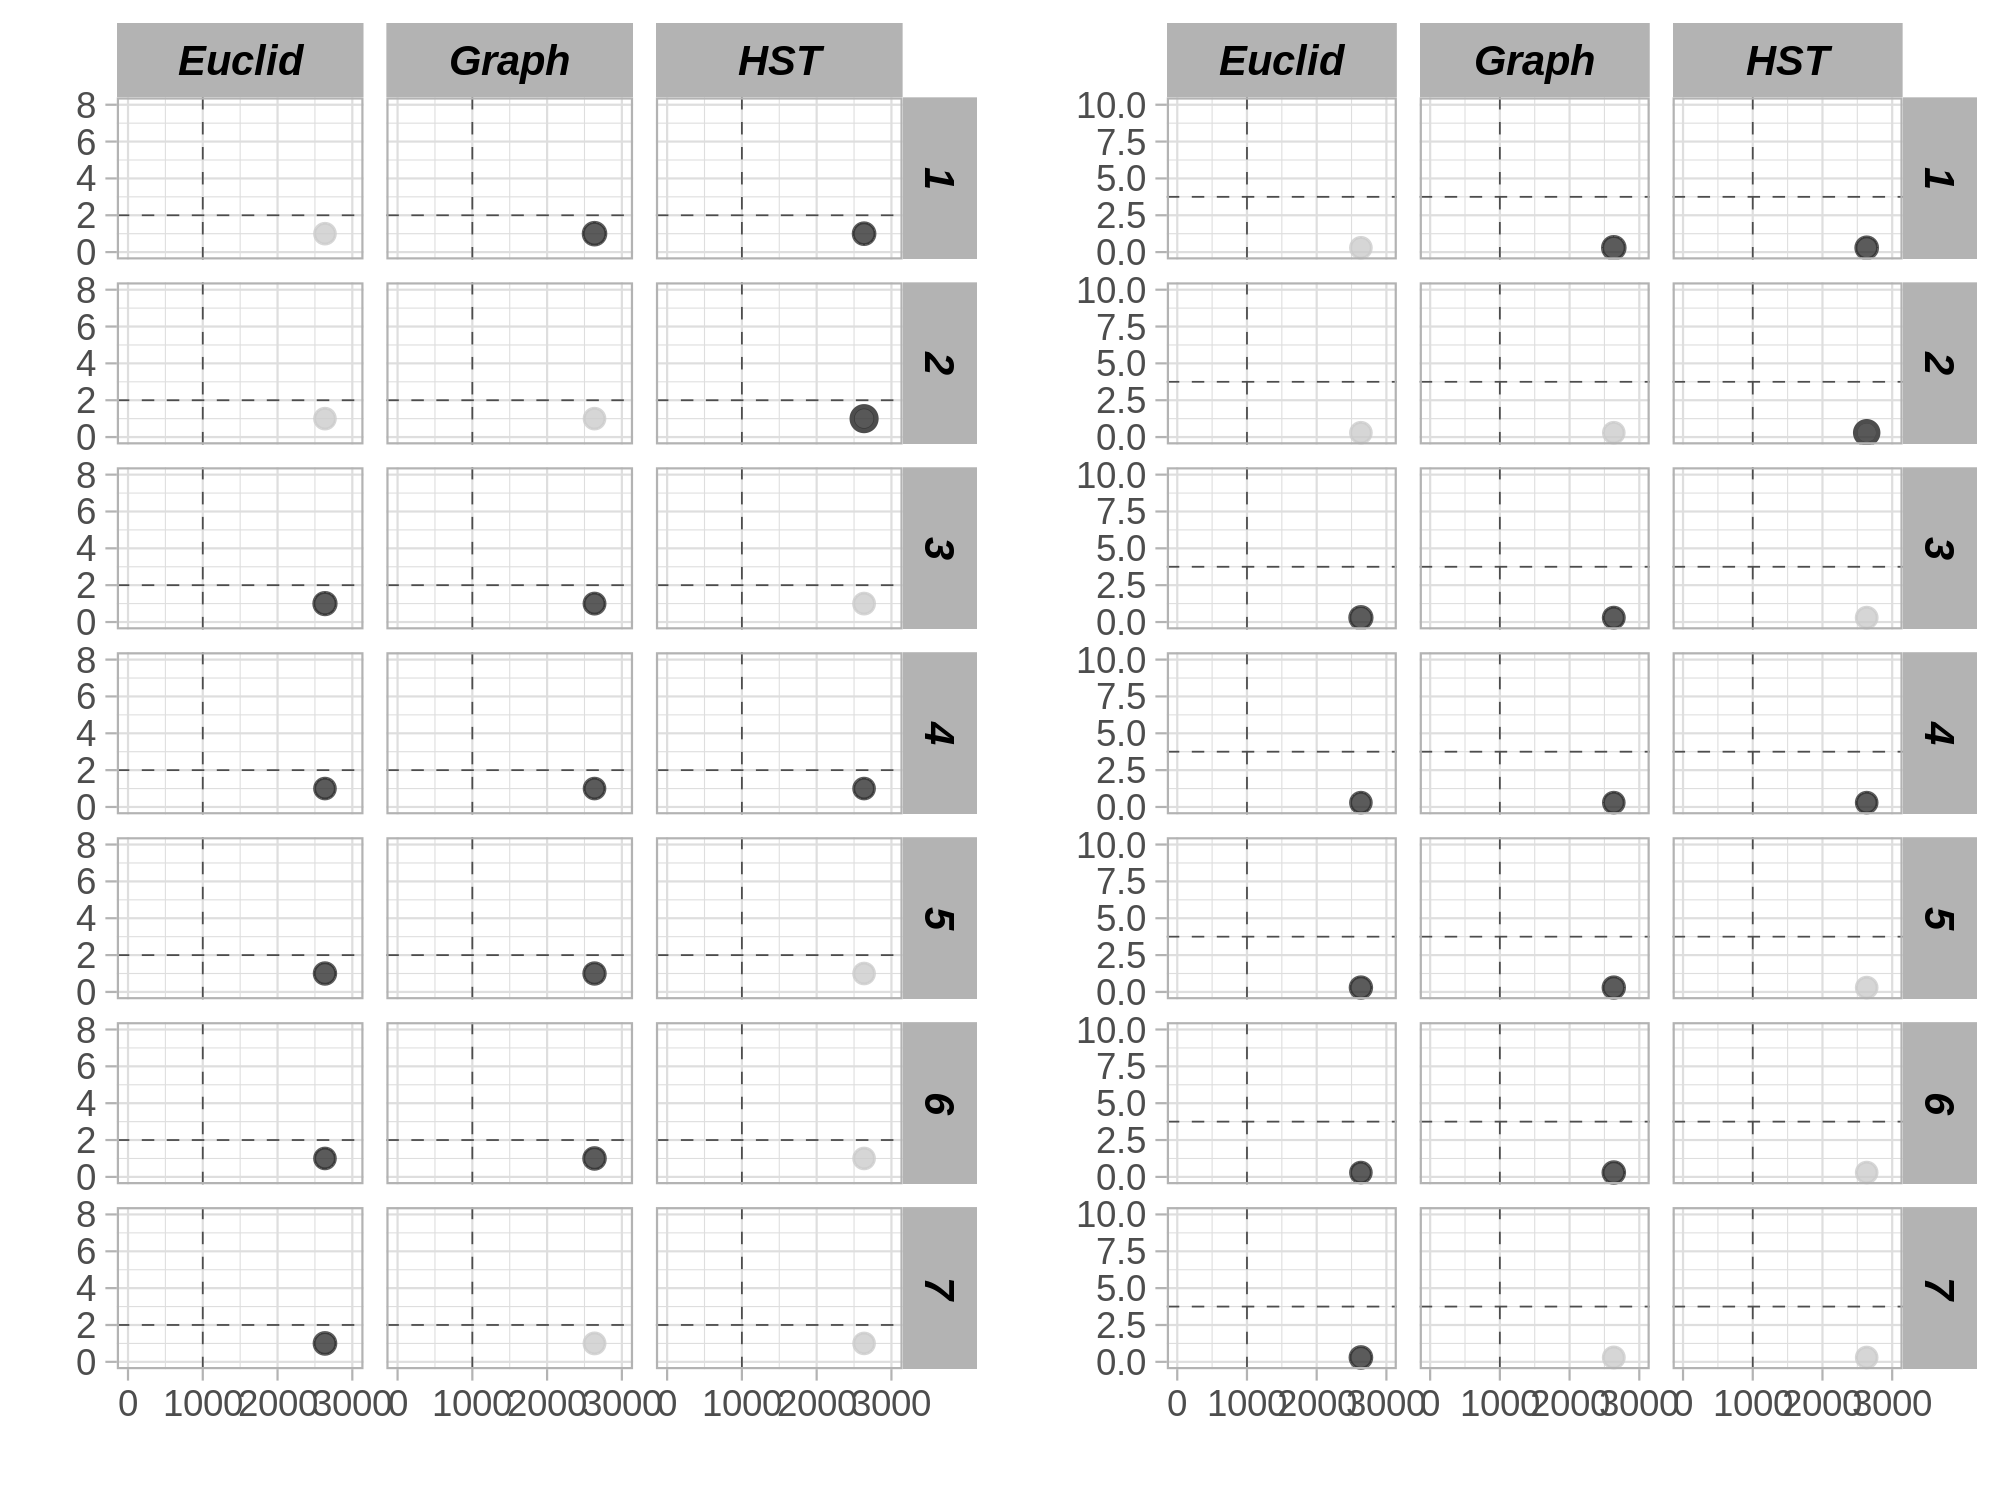

In [855]:
%%R -r 300 -w 2000 -h 1500
p_<-grid.arrange(p4,p5,ncol=2)
#ggsave(plot=p6,"./fig/p6.pdf",width=10,height=12)

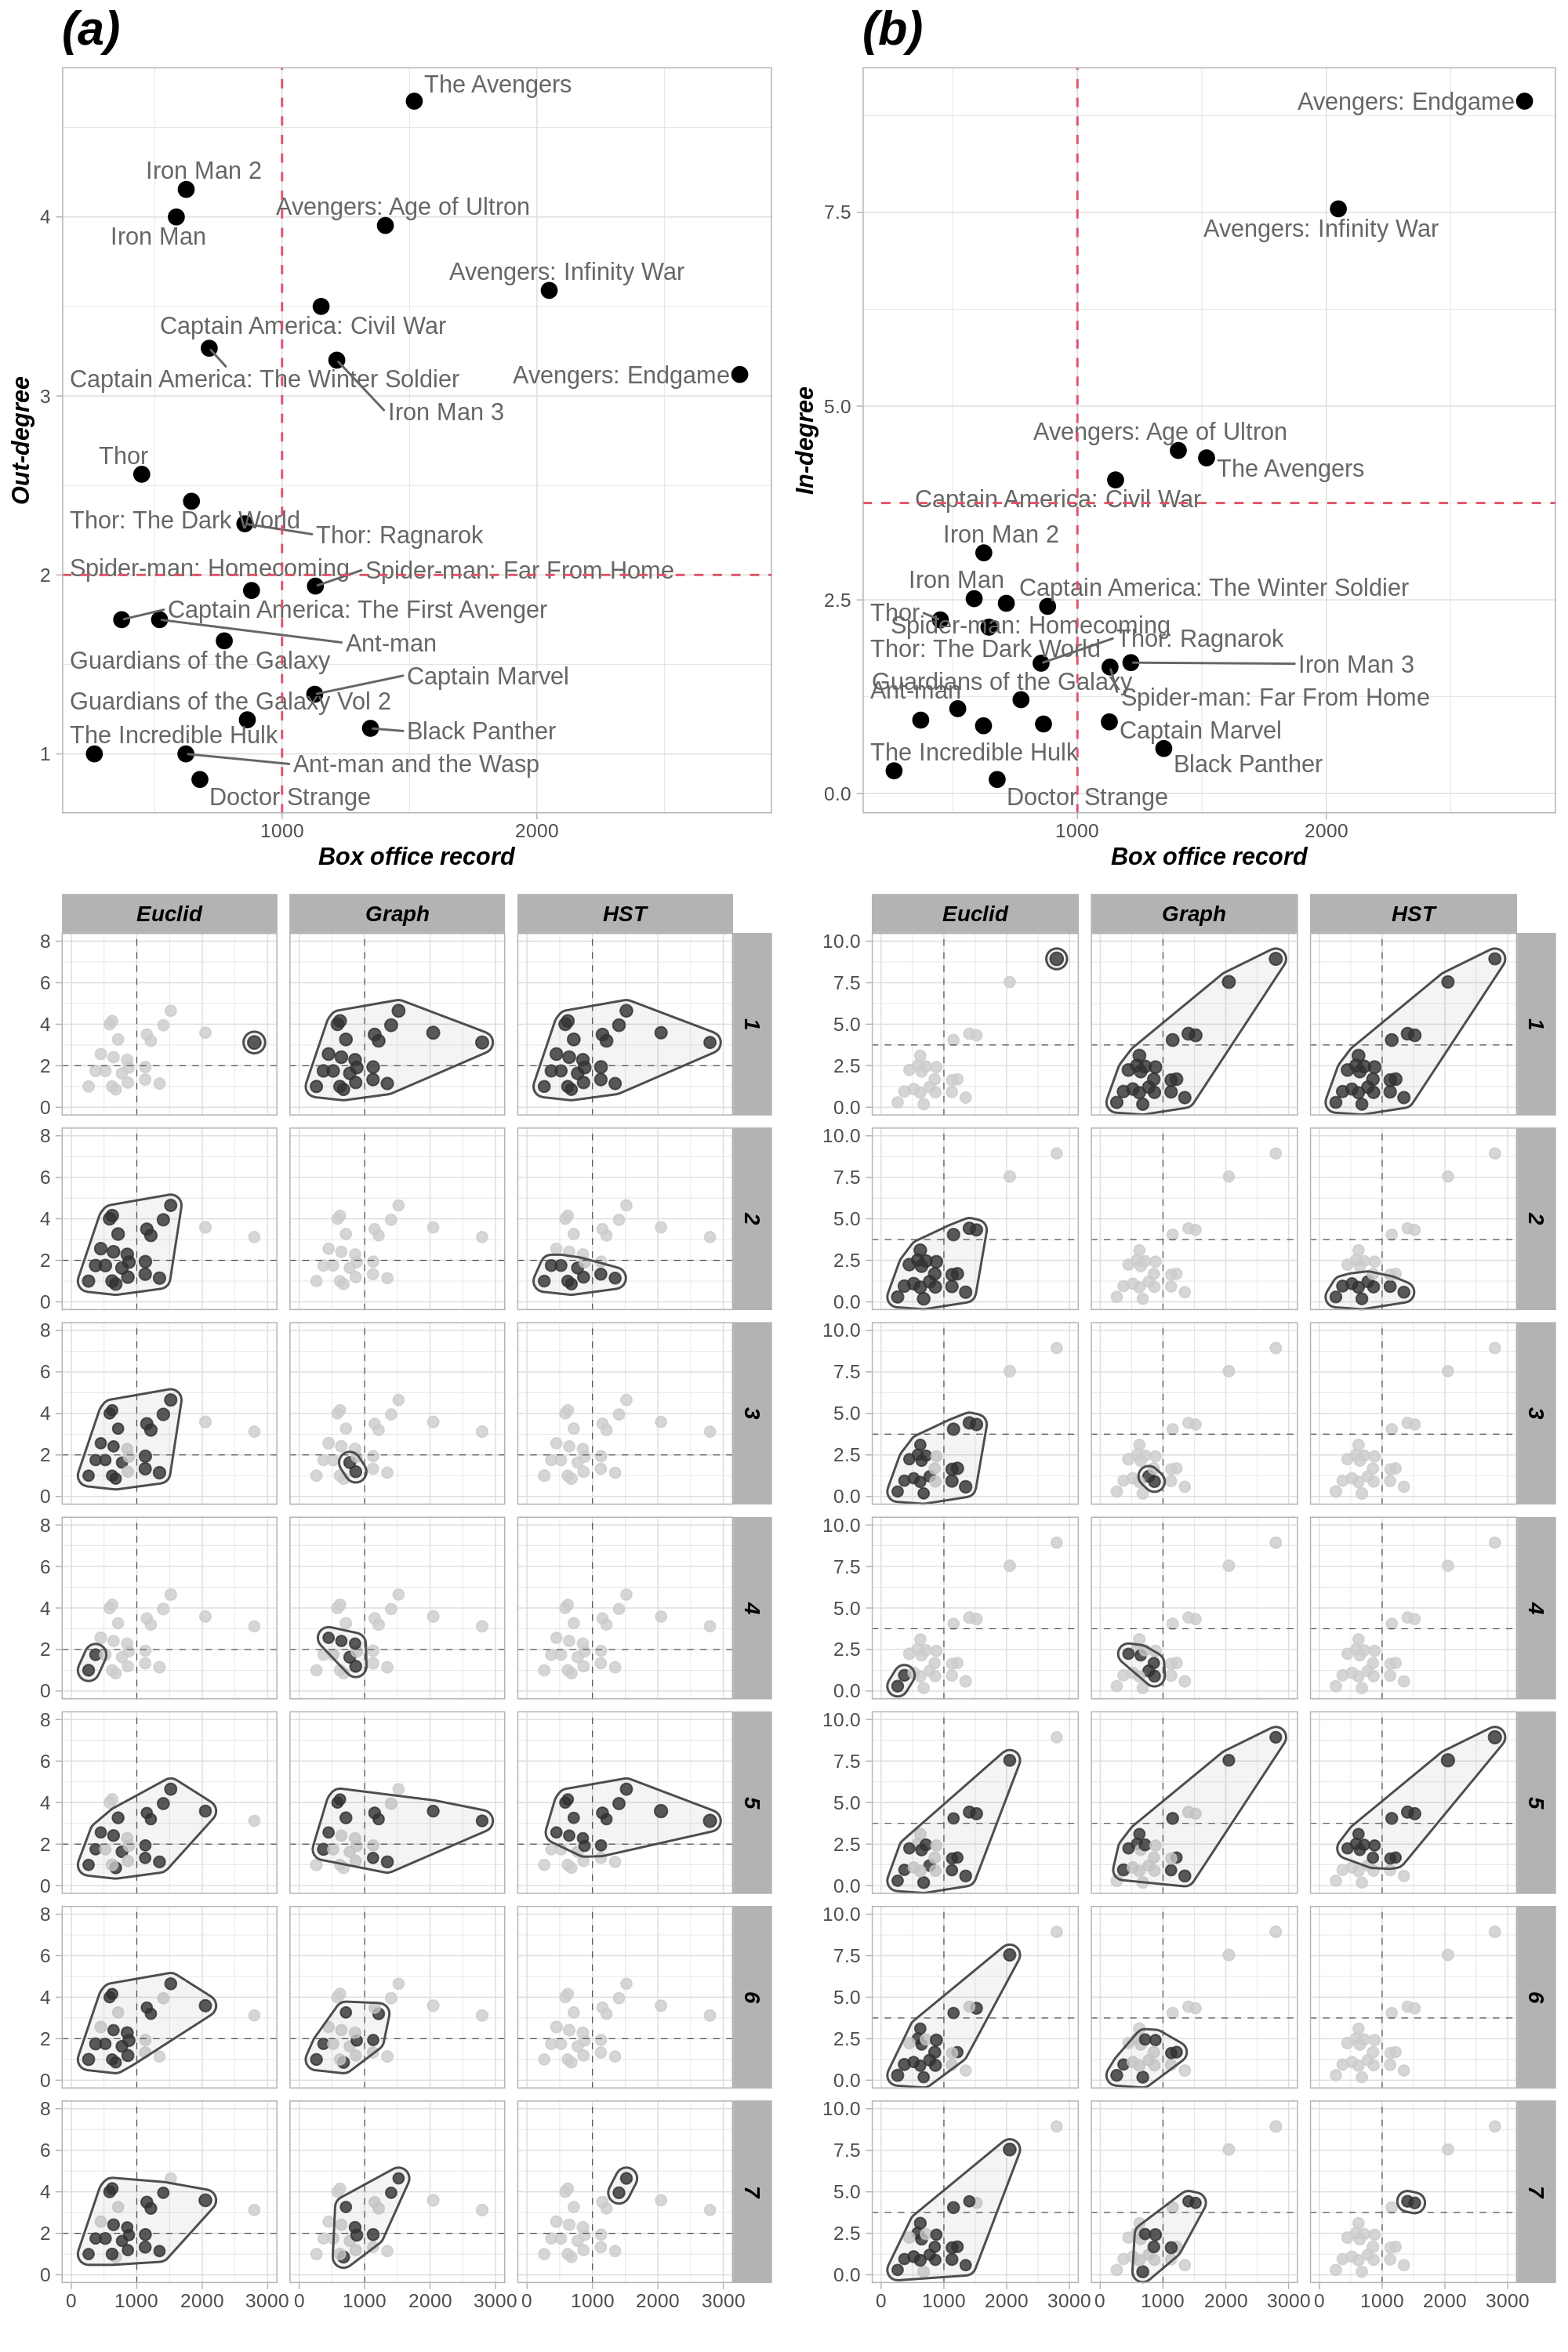

In [817]:
%%R -r 200 -w 2000 -h 3000
p6<-grid.arrange(p1,p_,nrow=2,heights=c(3,5))

In [7]:
%run heavysnow 
gs=GraphSignal(V,hst.snowweight,f)
spa=SpectralAnalysis(gs)

In [8]:
spa.n

23

In [9]:
spa.graphFouriertransform()
spa.decompose()

In [10]:
spa.V

array(['Iron Man', 'The Incredible Hulk', 'Iron Man 2', 'Thor',
       'Captain America: The First Avenger', 'The Avengers', 'Iron Man 3',
       'Thor: The Dark World', 'Captain America: The Winter Soldier',
       'Guardians of the Galaxy', 'Avengers: Age of Ultron', 'Ant-man',
       'Captain America: Civil War', 'Doctor Strange',
       'Guardians of the Galaxy Vol 2', 'Spider-man: Homecoming',
       'Thor: Ragnarok', 'Black Panther', 'Avengers: Infinity War',
       'Ant-man and the Wasp', 'Captain Marvel', 'Avengers: Endgame',
       'Spider-man: Far From Home'], dtype=object)

In [11]:
df=pd.DataFrame(spa.components)
df

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,6.247290e-15,1.707095e+03,-9.827837e-14,-8.486396e-14,2.899762e-14,6.041645e-15,-1.187456e-14,-3.502007e-13,-1.193541e-13,3.794379e-13,...,-1.121921e+03,-3.548465e-14,-1.892759e-14,4.544603e-13,-1.900950e-14,8.032471e-14,-8.990956e-10,-1.633610e-13,-7.430218e-14,-6.028971e-15
1,2.712215e-16,1.058137e-08,-5.007274e-14,3.386473e-17,1.420744e-11,-1.437544e-15,-1.321678e-14,4.039994e-15,-2.833873e-14,-1.633926e-10,...,-6.954407e-09,-4.113024e-11,4.516539e-14,5.644640e-16,-3.435360e-04,9.652342e-16,1.450493e+02,6.727200e-10,4.158595e-16,-1.646478e-14
2,5.567872e-01,-3.517889e-13,4.205928e+00,3.135672e-01,1.237232e-13,1.002442e+01,1.419019e+00,-6.420902e-01,-2.586033e+00,-3.800564e-15,...,4.504242e-14,3.881354e-15,-7.222631e+00,-1.270091e-01,-3.911058e-13,1.458953e+03,-6.970078e-17,-4.258602e-14,-7.984930e+02,-1.051491e+00
3,-1.059263e-14,-4.888031e-13,-2.398614e-13,-5.563074e-14,4.899172e-01,5.509354e-14,3.093273e-14,-5.194113e-13,-5.543531e-14,5.360109e+02,...,2.551620e-13,-1.247248e+02,-2.667641e-14,1.290511e-13,-1.099014e-04,-4.141358e-14,-1.039357e-10,3.755068e+01,-1.017089e-14,5.754851e-14
4,-1.338283e-14,3.813154e-13,5.864303e-14,6.890875e-14,1.634047e+02,-5.976314e-14,-2.108992e-14,2.695599e-13,7.059745e-14,-3.468382e+02,...,-4.555950e-13,-6.202443e+01,3.944487e-13,-2.381748e-13,-2.477574e-03,-3.908796e-14,-2.329564e-09,6.160302e+02,-3.849599e-14,-2.522857e-14
5,6.268624e-01,5.025556e-14,3.621003e+00,3.780309e+02,-3.789023e-13,-9.031218e-02,-6.086432e-01,1.451182e+03,-8.818405e-01,2.446920e-13,...,-4.128901e-13,-1.945880e-14,1.479923e+00,-3.154052e+02,2.823262e-20,2.283802e-02,-1.940234e-16,-4.831462e-14,-4.437603e-02,6.842734e-01
6,3.634492e+00,0.000000e+00,2.251986e+01,3.648403e+02,1.237232e-13,-5.152353e-01,-5.098148e+00,-4.000544e+02,-8.218727e+00,-8.219362e-14,...,3.071239e-13,4.246548e-15,1.439908e+01,1.215892e+03,-2.276049e-20,1.454592e-01,1.091523e-16,2.670230e-14,-3.092549e-01,4.780988e+00
7,-1.469804e+00,2.680297e-13,-1.084964e+01,-2.645684e-01,6.263487e-13,1.490922e+02,1.817207e+00,1.485871e+00,5.348931e+00,-2.997392e-13,...,2.165643e-13,2.126956e-14,1.003275e+01,1.777094e+00,9.978330e-19,-1.753933e+00,2.539023e-15,1.997032e-13,6.687601e+00,-7.156614e-01
8,-8.116393e+00,1.675185e-13,-6.823096e+01,-2.585005e+00,-1.546540e-13,8.415274e+01,6.742951e+00,1.147843e+01,3.914723e+01,-5.540890e-14,...,-1.694475e-13,6.807886e-16,7.498935e+01,1.348579e+01,-3.385392e-18,-6.612900e+00,-3.888607e-15,1.516414e-13,2.824586e+01,-6.751284e-01
9,-1.457985e+02,1.340148e-13,9.688547e+02,-1.627500e-01,3.093080e-14,7.405009e-01,-1.841870e+00,2.753373e+00,-5.049281e+01,2.737548e-14,...,-8.177666e-14,-7.010920e-15,-8.832644e+00,4.080923e+00,5.407829e-20,-7.998628e-02,3.110801e-15,-6.383287e-14,3.682641e-01,1.447229e+00


In [12]:
df=df.stack().reset_index().rename(columns={'level_0':'vertex','level_1':'comp',0:'fhat'})

In [13]:
df 

,vertex,comp,fhat
0,0,0,6.247290e-15
1,0,1,1.707095e+03
2,0,2,-9.827837e-14
3,0,3,-8.486396e-14
4,0,4,2.899762e-14
...,...,...,...
524,22,18,-5.630576e+01
525,22,19,4.698508e+01
526,22,20,-2.262072e+02
527,22,21,-2.358328e+01


In [14]:
df['fill']= df.fhat >0 

In [15]:
df

,vertex,comp,fhat,fill
0,0,0,6.247290e-15,True
1,0,1,1.707095e+03,True
2,0,2,-9.827837e-14,False
3,0,3,-8.486396e-14,False
4,0,4,2.899762e-14,True
...,...,...,...,...
524,22,18,-5.630576e+01,False
525,22,19,4.698508e+01,True
526,22,20,-2.262072e+02,False
527,22,21,-2.358328e+01,False


In [19]:
n=23
fig=ggplot(df)
facet=facet_wrap('comp',ncol=1)
aes1=aes(x='vertex',y='fhat',fill='fill')
aes3=aes(x='vertex',y='fhat',label=spa.V)
geom1=geom_col(aes1,alpha=0.8)
geom2=geom_hline(yintercept = 0,linetype='dashed',color='gray',size=0.3)
#geom3=geom_text_repel(aes(x=Vindex,y=fhat,label=V)

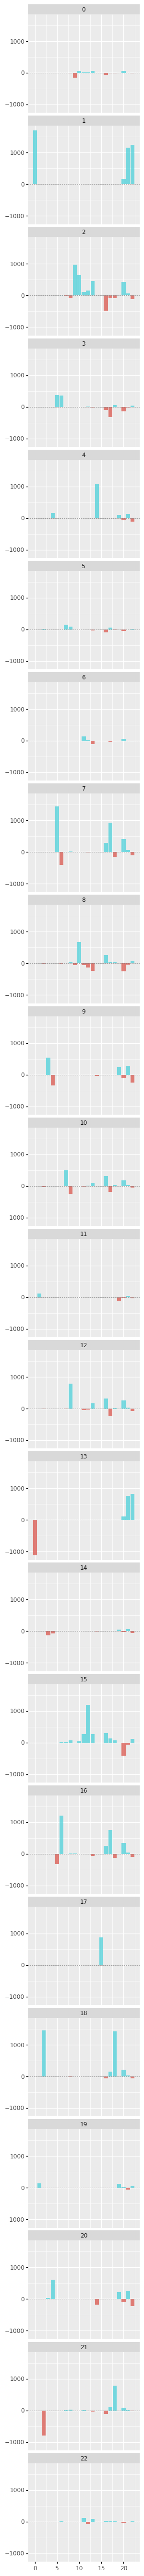

<ggplot: (8757733928385)>

In [20]:
fig+facet+geom1+geom2+xlab("")+ylab("")+theme(figure_size=(3, 3*n))+theme(legend_position="none")